 제주도 도로 교통량 예측 
====================
데이터 정보 
-------------
train.csv  
- 2022년 8월 이전 데이터만 존재 (단, 날짜가 모두 연속적이지 않음)  
- 4,701,217개의 데이터 (470만여건)  
- id : 샘플 별 고유 id  
- 날짜, 시간, 교통 및 도로구간 등 정보  
- target 변수 : 도로의 차량 평균 속도(km)  
  
train.csv 
- 2022년 8월 데이터만 존재 (단, 날짜가 모두 연속적이지 않음)  
- 291,241개의 데이터  
- id : 샘플 별 고유 id  
- 날짜, 시간, 교통 및 도로구간 등 정보  

         
데이터의 각 Column별 설명 
-------------
id : 아이디   
base_date : 날짜   
day_of_week : 요일  
base_hour : 시간대  
road_in_use : 도로사용여부  
lane_count : 차로수  
road_rating : 도로등급  
multi_linked : 중용구간 여부  
connect_code : 연결로 코드  
maximum_speed_limit : 최고속도제한  
weight_restricted : 통과제한하중  
height_restricted : 통과제한높이  
road_type : 도로유형  
start_latitude : 시작지점의 위도  
start_longitude : 시작지점의 경도  
start_turn_restricted : 시작 지점의 회전제한 유무  
end_latitude : 도착지점의 위도  
end_longitude : 도착지점의 경도  
end_turn_restricted : 도작지점의 회전제한 유무  
road_name : 도로명  
start_node_name : 시작지점명  
end_node_name : 도착지점명  
vehicle_restricted : 통과제한차량  
target : 평균속도(km)  


## 외부데이터 

날씨 데이터 
- 출처 : [기상청 기상자료개방포털](https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36)  
-  21.9월부터 22.8월까지 비,눈 데이터

    

 공휴일 데이터   
 - 출처 :[공공데이터](https://www.data.go.kr/tcs/dss/selectApiDataDetailView.do?publicDataPk=15012690)
 - 21.9월부터 22.8월까지 공휴일  

# Import 

In [142]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
import gc
from matplotlib import rc 
rc('font', family='AppleGothic')#맥 한글깨짐
from math import radians, cos, sin, asin, sqrt
from collections import Counter
import warnings  
warnings.filterwarnings('ignore')

## csv to parquet

-  메모리에 효율적인 데이터 유형을 사용하여 용량을 크게 줄이고 빠른 작업이 가능

In [82]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'data/{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')


In [83]:
csv_to_parquet('data/train.csv', 'train')
csv_to_parquet('data/test.csv', 'test')

train Done.
test Done.


In [84]:
#데이터 불러오기
df_train=pd.read_parquet("data/train.parquet")
df_test=pd.read_parquet("data/test.parquet")


#외부 데이터 불러오기
df_rain_snow= pd.read_csv("data/rain_snow.csv")
df_holiday = pd.read_csv("data/holiday.csv")


## 데이터 정보

In [85]:
df_train.head(10)

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0
5,TRAIN_0000005,20210913,월,7,2,107,경찰로,0,0,60.0,...,0,시청입구2,33.249949,126.505664,없음,서호2차현대맨션203동,33.252183,126.506069,없음,28.0
6,TRAIN_0000006,20220106,목,0,2,107,-,0,0,60.0,...,0,가동,33.418412,126.268029,없음,나동,33.414175,126.269378,없음,39.0
7,TRAIN_0000007,20211213,월,16,2,107,외도천교,0,0,60.0,...,3,외도천교,33.482392,126.441622,없음,외도천교,33.482332,126.442266,없음,28.0
8,TRAIN_0000008,20211004,월,15,2,107,경찰로,0,0,60.0,...,0,신성교회,33.253074,126.506393,없음,서호2차현대맨션203동,33.252183,126.506069,없음,14.0
9,TRAIN_0000009,20211208,수,2,1,103,일반국도16호선,0,0,50.0,...,0,양수장,33.361717,126.766958,없음,제2가시교,33.364336,126.769409,없음,52.0


In [86]:
df_train.shape

(4701217, 23)

In [87]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int64  
 2   day_of_week            object 
 3   base_hour              int64  
 4   lane_count             int64  
 5   road_rating            int64  
 6   road_name              object 
 7   multi_linked           int64  
 8   connect_code           int64  
 9   maximum_speed_limit    float64
 10  vehicle_restricted     float64
 11  weight_restricted      float64
 12  height_restricted      float64
 13  road_type              int64  
 14  start_node_name        object 
 15  start_latitude         float64
 16  start_longitude        float64
 17  start_turn_restricted  object 
 18  end_node_name          object 
 19  end_latitude           float64
 20  end_longitude          float64
 21  end_turn_restricted    object 
 22  target            

## 결측치 확인
- 결측값 없음 

In [88]:
df_train.isnull().sum()

id                       0
base_date                0
day_of_week              0
base_hour                0
lane_count               0
road_rating              0
road_name                0
multi_linked             0
connect_code             0
maximum_speed_limit      0
vehicle_restricted       0
weight_restricted        0
height_restricted        0
road_type                0
start_node_name          0
start_latitude           0
start_longitude          0
start_turn_restricted    0
end_node_name            0
end_latitude             0
end_longitude            0
end_turn_restricted      0
target                   0
dtype: int64

## 고유값 확인 
- vehicle_restricted , height_restricted 컬럼은 한가지 값만 존재하므로 삭제
- 날짜데이터를 년,월,일로 컬럼 추가 

In [89]:
df_train.nunique()

id                       4701217
base_date                    281
day_of_week                    7
base_hour                     24
lane_count                     3
road_rating                    3
road_name                     61
multi_linked                   2
connect_code                   2
maximum_speed_limit            6
vehicle_restricted             1
weight_restricted              4
height_restricted              1
road_type                      2
start_node_name              487
start_latitude               586
start_longitude              586
start_turn_restricted          2
end_node_name                487
end_latitude                 586
end_longitude                586
end_turn_restricted            2
target                       102
dtype: int64

In [90]:
df_test.nunique()

id                       291241
base_date                    31
day_of_week                   7
base_hour                    24
lane_count                    3
road_rating                   3
road_name                    46
multi_linked                  1
connect_code                  1
maximum_speed_limit           5
vehicle_restricted            1
weight_restricted             4
height_restricted             1
road_type                     2
start_node_name             250
start_latitude              294
start_longitude             294
start_turn_restricted         2
end_node_name               252
end_latitude                296
end_longitude               296
end_turn_restricted           2
dtype: int64

In [91]:
#컬럼 삭제
df_train.drop(['vehicle_restricted',"height_restricted"],axis=1,inplace=True)
df_test.drop(["vehicle_restricted", "height_restricted"], axis = 1, inplace = True)

## 데이터 병합 
- `날씨데이터(비,눈)` 날짜기준으로 비,눈이 온 날과 안 온날로 데이터 병합
- ` 공휴일 데이터`를 통해 `평일(월,화,수,목) = 0 , 금요일 = 1 , 공휴일(공휴일, 토,일) =2`로 나누기

In [92]:
# train 데이터 & 날씨 데이터 병합
df_train_merge=df_train.copy()

df_train_merge=pd.merge(df_train_merge,df_rain_snow, how='left',on=['base_date'])
df_train_merge['rain_snow']= df_train_merge['rain_snow'].fillna('없음')
df_train_merge.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,rain_snow
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0,눈비
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0,눈비
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0,눈비
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0,없음
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0,없음


In [93]:
# test 데이터 & 날씨 데이터 병합
df_test_merge=df_test.copy()

df_test_merge=pd.merge(df_test_merge,df_rain_snow, how='left',on=['base_date'])
df_test_merge['rain_snow']= df_test_merge['rain_snow'].fillna('없음')
df_test_merge.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,rain_snow
0,TEST_000000,20220825,목,17,3,107,연삼로,0,0,70.0,...,0,산지2교,33.499427,126.541298,없음,제주은행사거리,33.500772,126.543837,있음,없음
1,TEST_000001,20220809,화,12,2,103,일반국도12호선,0,0,70.0,...,3,중문입구,33.258507,126.427003,없음,관광단지입구,33.258119,126.415840,없음,눈비
2,TEST_000002,20220805,금,2,1,103,일반국도16호선,0,0,60.0,...,0,도순3교,33.258960,126.476508,없음,도순2교,33.259206,126.474687,없음,눈비
3,TEST_000003,20220818,목,23,3,103,일반국도11호선,0,0,70.0,...,0,아라주공아파트,33.473494,126.545647,없음,인다마을,33.471061,126.545467,없음,없음
4,TEST_000004,20220810,수,17,3,106,번영로,0,0,70.0,...,0,부록교 시종점,33.501477,126.569223,없음,봉개교 시종점,33.496863,126.581230,없음,눈비


In [94]:
#train 데이터 & 휴일 데이터 병합
df_train_holiday=pd.merge(df_train_merge,df_holiday, how='left',on=['base_date'])
train_holiday = (df_train_holiday['day_of_week'] == '토') | (df_train_holiday['day_of_week'] == '일') 
df_train_holiday.loc[(df_train_holiday['day_of_week'] == '금'),'week'] = 1
df_train_holiday.loc[train_holiday, 'week'] = 2
df_train_holiday['week'] = df_train_holiday['week'].fillna(0)

df_train_holiday.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,rain_snow,week
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0,눈비,0.0
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0,눈비,0.0
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0,눈비,2.0
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0,없음,1.0
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0,없음,0.0


In [95]:
#test 데이터 & 휴일 데이터 병합
df_test_holiday=pd.merge(df_test_merge,df_holiday, how='left',on=['base_date'])
test_holiday =(df_test_holiday['day_of_week'] == '토') | (df_test_holiday['day_of_week'] == '일') 
df_test_holiday.loc[(df_test_holiday['day_of_week'] == '금'),'week'] = 1
df_test_holiday.loc[test_holiday, 'week'] = 2
df_test_holiday['week'] = df_test_holiday['week'].fillna(0)

df_test_holiday.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,rain_snow,week
0,TEST_000000,20220825,목,17,3,107,연삼로,0,0,70.0,...,산지2교,33.499427,126.541298,없음,제주은행사거리,33.500772,126.543837,있음,없음,0.0
1,TEST_000001,20220809,화,12,2,103,일반국도12호선,0,0,70.0,...,중문입구,33.258507,126.427003,없음,관광단지입구,33.258119,126.415840,없음,눈비,0.0
2,TEST_000002,20220805,금,2,1,103,일반국도16호선,0,0,60.0,...,도순3교,33.258960,126.476508,없음,도순2교,33.259206,126.474687,없음,눈비,1.0
3,TEST_000003,20220818,목,23,3,103,일반국도11호선,0,0,70.0,...,아라주공아파트,33.473494,126.545647,없음,인다마을,33.471061,126.545467,없음,없음,0.0
4,TEST_000004,20220810,수,17,3,106,번영로,0,0,70.0,...,부록교 시종점,33.501477,126.569223,없음,봉개교 시종점,33.496863,126.581230,없음,눈비,0.0


## 년, 월, 일 컬럼 추가

In [96]:
#train 데이터 추가
df_train_day = df_train_holiday.copy()
df_train_day["base_date"]= pd.to_datetime(df_train["base_date"],format='%Y%m%d')
df_train_day['year']= df_train_day['base_date'].dt.year
df_train_day['month']= df_train_day['base_date'].dt.month
df_train_day['day']= df_train_day['base_date'].dt.day

df_train_day.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,rain_snow,week,year,month,day
0,TRAIN_0000000,2022-06-23,목,17,1,106,지방도1112호선,0,0,60.0,...,제3교래교,33.427749,126.662335,없음,52.0,눈비,0.0,2022,6,23
1,TRAIN_0000001,2022-07-28,목,21,2,103,일반국도11호선,0,0,60.0,...,KAL사거리,33.504811,126.526240,없음,30.0,눈비,0.0,2022,7,28
2,TRAIN_0000002,2021-10-10,일,7,2,103,일반국도16호선,0,0,80.0,...,상창육교,33.280072,126.362147,없음,61.0,눈비,2.0,2021,10,10
3,TRAIN_0000003,2022-03-11,금,13,2,107,태평로,0,0,50.0,...,서현주택,33.245565,126.566228,없음,20.0,없음,1.0,2022,3,11
4,TRAIN_0000004,2021-10-05,화,8,2,103,일반국도12호선,0,0,80.0,...,애월입구,33.462677,126.330152,없음,38.0,없음,0.0,2021,10,5


In [97]:
#테스트 데이터 추가
df_test_day = df_test_holiday.copy()
df_test_day["base_date"]= pd.to_datetime(df_test["base_date"],format='%Y%m%d')
df_test_day['year']= df_test_day['base_date'].dt.year
df_test_day['month']= df_test_day['base_date'].dt.month
df_test_day['day']= df_test_day['base_date'].dt.day

df_test_day.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,rain_snow,week,year,month,day
0,TEST_000000,2022-08-25,목,17,3,107,연삼로,0,0,70.0,...,없음,제주은행사거리,33.500772,126.543837,있음,없음,0.0,2022,8,25
1,TEST_000001,2022-08-09,화,12,2,103,일반국도12호선,0,0,70.0,...,없음,관광단지입구,33.258119,126.415840,없음,눈비,0.0,2022,8,9
2,TEST_000002,2022-08-05,금,2,1,103,일반국도16호선,0,0,60.0,...,없음,도순2교,33.259206,126.474687,없음,눈비,1.0,2022,8,5
3,TEST_000003,2022-08-18,목,23,3,103,일반국도11호선,0,0,70.0,...,없음,인다마을,33.471061,126.545467,없음,없음,0.0,2022,8,18
4,TEST_000004,2022-08-10,수,17,3,106,번영로,0,0,70.0,...,없음,봉개교 시종점,33.496863,126.581230,없음,눈비,0.0,2022,8,10


# EDA

## 상관관계 분석


In [98]:
#object데이터는 상관관계 게산을 위해 encoder
items = ['day_of_week','road_name','start_node_name','start_turn_restricted','end_node_name',"end_turn_restricted","rain_snow"]
df_corr = df_train_day.copy()
endcoder =LabelEncoder()

for i in items : 
    encoder = LabelEncoder()
    encoder.fit(df_corr[i])
    df_corr[i] = encoder.transform(df_corr[i])


df_corr.drop(['id','base_date'],axis=1,inplace=True) #id컬럼은 빼고 진행 
df_corr.head()

,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,weight_restricted,road_type,...,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,rain_snow,week,year,month,day
0,1,17,1,106,46,0,0,60.0,32400.0,3,...,386,33.427749,126.662335,0,52.0,0,0.0,2022,6,23
1,1,21,2,103,34,0,0,60.0,0.0,0,...,2,33.504811,126.526240,0,30.0,0,0.0,2022,7,28
2,4,7,2,103,36,0,0,80.0,0.0,0,...,179,33.280072,126.362147,0,61.0,0,2.0,2021,10,10
3,0,13,2,107,57,0,0,50.0,0.0,0,...,203,33.245565,126.566228,0,20.0,1,1.0,2022,3,11
4,6,8,2,103,35,0,0,80.0,0.0,0,...,269,33.462677,126.330152,0,38.0,1,0.0,2021,10,5


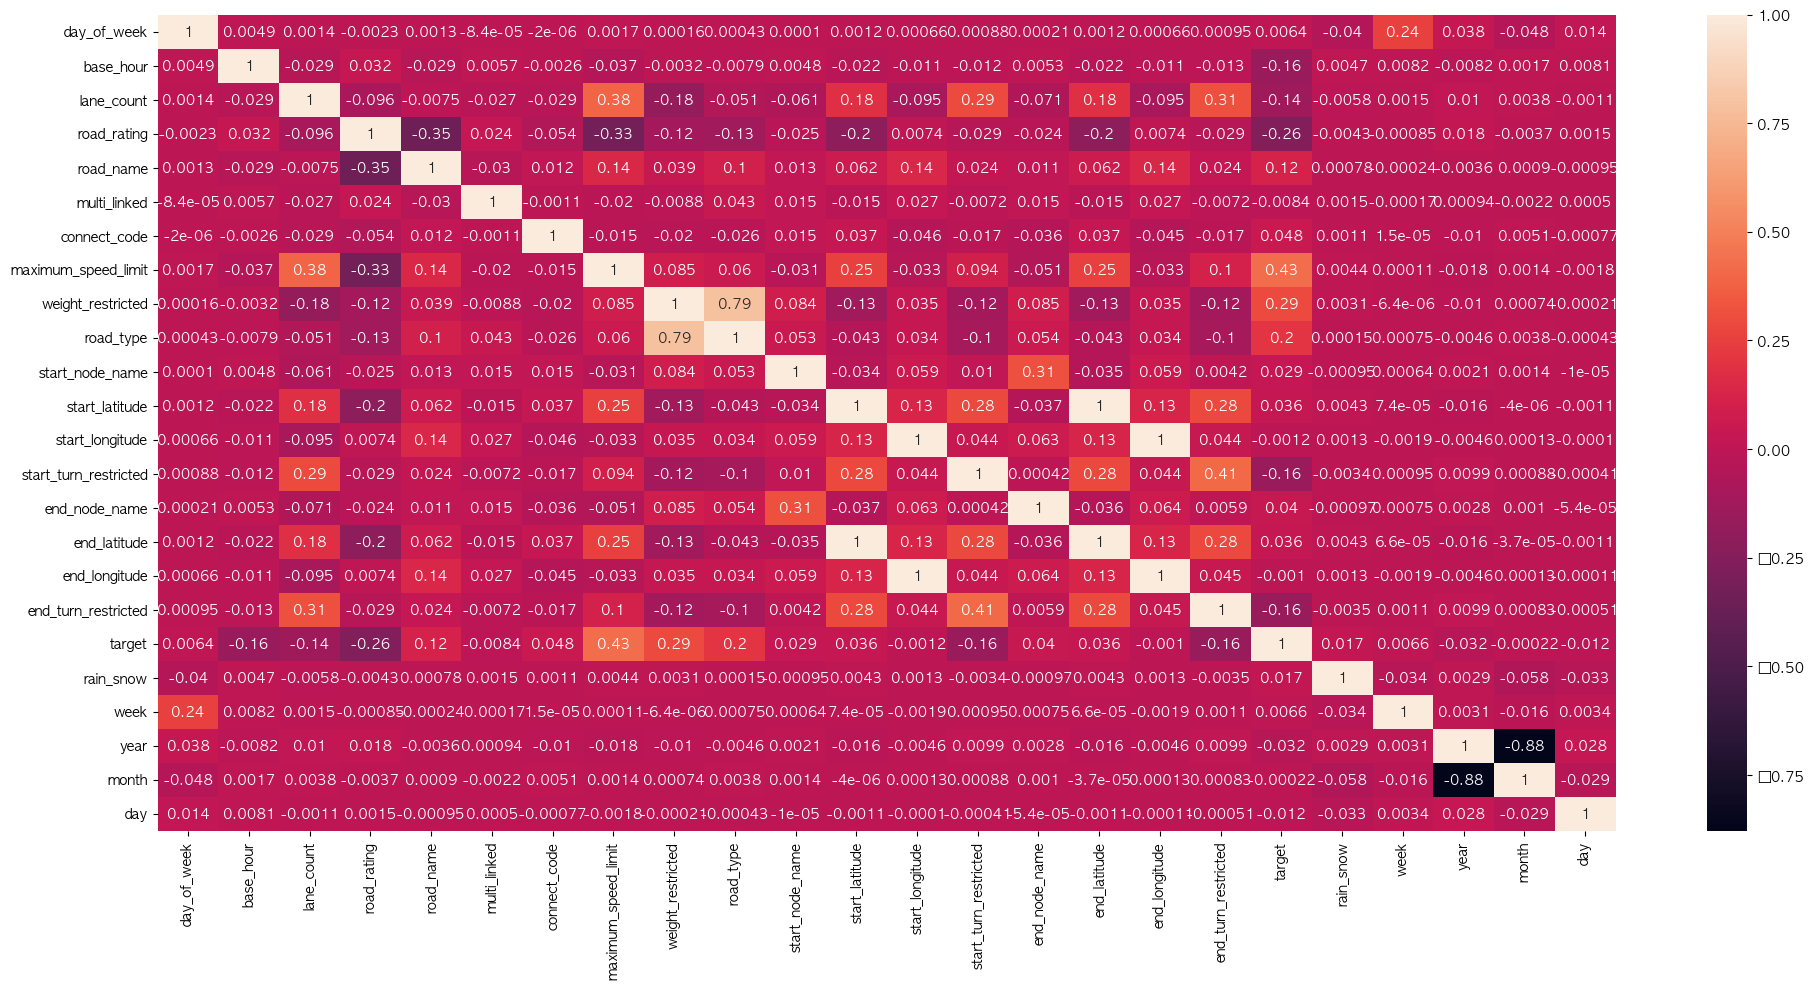

In [99]:
plt.figure(figsize=(20,10))
sns.heatmap(df_corr.corr(),annot=True)
         
plt.tight_layout()
plt.show()


In [100]:
df_corr.corr()['target'].sort_values()

road_rating             -0.261693
end_turn_restricted     -0.162815
base_hour               -0.159407
start_turn_restricted   -0.156121
lane_count              -0.144256
year                    -0.031676
day                     -0.011605
multi_linked            -0.008408
start_longitude         -0.001168
end_longitude           -0.001000
month                   -0.000225
day_of_week              0.006397
week                     0.006619
rain_snow                0.017385
start_node_name          0.029007
end_latitude             0.036139
start_latitude           0.036280
end_node_name            0.039770
connect_code             0.048348
road_name                0.116778
road_type                0.200840
weight_restricted        0.294092
maximum_speed_limit      0.425715
target                   1.000000
Name: target, dtype: float64

- `maximum_speed_limit` ,`weight_restricted` column이 상관관계가 높은것으로 나타남.
- `lane_coun(차로 수)`가 많을수록 속도가 더 높을 것으로 예측했지만 target과의 음의 관계로 차로수가 높을수록 속도가 더 높다는것을 알 수 있다. 
- `road_rating` ,` road_type`가 상관계수가 높은걸 봐서 도로의 유형과 형태가 속도에 영향을 줄 것으로 추측

## 데이터 날짜 확인 

- train 데이터 21.09.01부터 22.07.31까지 존재 (8월 데이터는 존재하지 않음 )
- test 데이터 22년 8월 데이터 

In [101]:
print('train 데이터 시작일 : ',np.min(df_train['base_date'].values))
print('train 데이터 종료일 : ',np.max(df_train['base_date'].values))

train 데이터 시작일 :  20210901
train 데이터 종료일 :  20220731


In [102]:
print('test 데이터 시작일 : ',np.min(df_test['base_date'].values))
print('test 데이터 종료일 : ',np.max(df_test['base_date'].values))

test 데이터 시작일 :  20220801
test 데이터 종료일 :  20220831


## 함수

In [103]:
#그룹에 따라 평균 속도 함수
def groupby_target (col):
    df_groupby = df_train_day[[col,'target']]
    df_groupby = df_groupby.groupby(col).mean().reset_index()
   
    return df_groupby

## 최고 제한 속도(maximum_speed_limit)


In [104]:
df_train['maximum_speed_limit'].value_counts()

maximum_speed_limit
60.0    1665573
50.0    1103682
70.0     995077
80.0     700334
30.0     229761
40.0       6790
Name: count, dtype: int64

In [152]:
statistics(df_train,'maximum_speed_limit')

maximum_speed_limit의 최대값 : 113.0
maximum_speed_limit의 최소값 : 1.0
maximum_speed_limit의 평균값 : 42.78844180134633
maximum_speed_limit의 중앙값 : 43.0
maximum_speed_limit의 최빈값 1순위 : 60.0 & 1665573개
maximum_speed_limit의 최빈값 2순위 : 50.0 & 1103682개
maximum_speed_limit의 최빈값 3순위 : 70.0 & 995077개


<Axes: xlabel='maximum_speed_limit', ylabel='Density'>

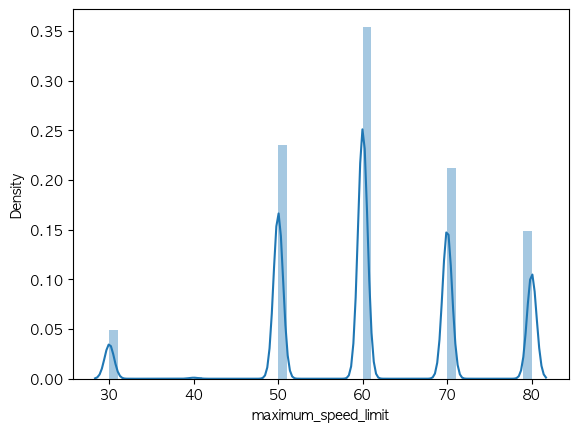

In [105]:
# 최고 제한 속도 시각화
sns.distplot(df_train.maximum_speed_limit)

In [106]:
df_groupby_maximum=groupby_target('maximum_speed_limit')

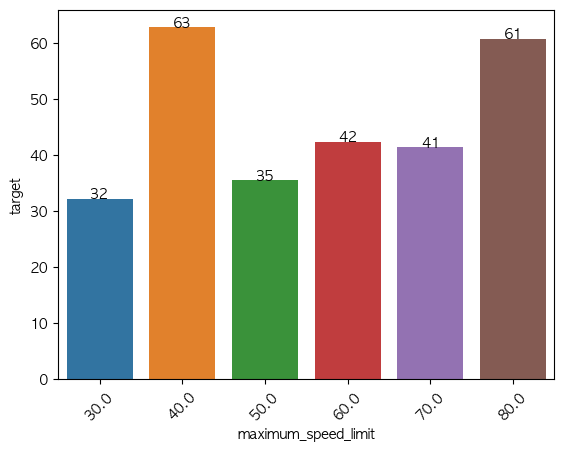

In [107]:
plt.xticks(rotation=45)


ax=sns.barplot(x='maximum_speed_limit',y='target',data=df_groupby_maximum)

for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, # x 좌표
            p.get_y() + p.get_height() , # y 좌표
            f"{p.get_height():.0f}", # 값
            ha='center') # 가운데 정렬
plt.show()


<Axes: xlabel='maximum_speed_limit', ylabel='target'>

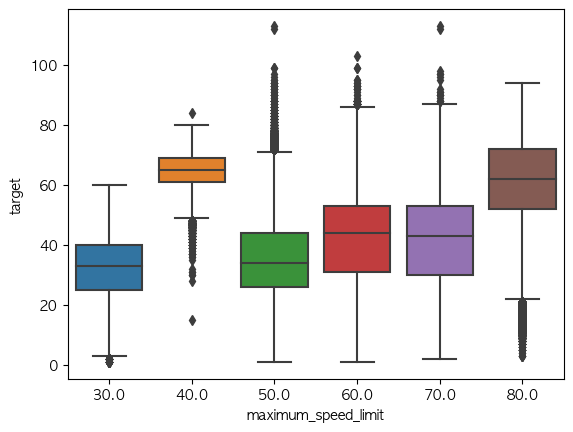

In [108]:
#이상치
sns.boxplot(x = "maximum_speed_limit", y = "target", data = df_train)

- 제한속도가 40일때 가장 평균이 높지만, 제한 속도가 40인 데이터 비중이 미미하다. 

## 차로 수(lane_count)


In [109]:
df_train['lane_count'].value_counts()

lane_count
2    2352092
1    1558531
3     790594
Name: count, dtype: int64

In [110]:
df_groupby_lane = groupby_target ('lane_count')
df_groupby_lane

,lane_count,target
0,1,43.570562
1,2,44.915713
2,3,34.917783


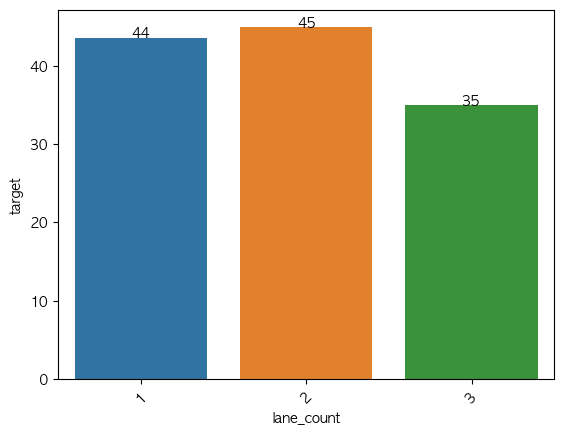

In [111]:
plt.xticks(rotation=45)


ax=sns.barplot(x='lane_count',y='target',data=df_groupby_lane)

for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2,
            p.get_y() + p.get_height() ,
            f"{p.get_height():.0f}", 
            ha='center')
plt.show()


<Axes: xlabel='lane_count', ylabel='target'>

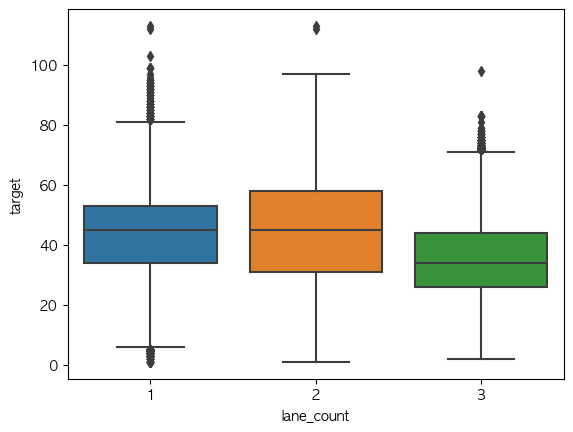

In [112]:
sns.boxplot(x = "lane_count", y = "target", data = df_train)

- 차로수가 많을수록 도로가 넓어지므로 속도가 높을것으로 예상하였지만 차로수가 1,2 일떄보다 3차선일때 평균 속도가 느린 것으로 확인
- 차량 통행량이 많은 곳이라서 도로가 3차선까지 있는 것이고 기본 차량 통행량이 많은 곳이니 속도가 느려짐

## 도로 등급(road_rating)
- 103 -> 일반국도 , 106-> 지방도, 107 -> 시도 군도

In [138]:
df_train['road_rating'].value_counts()

road_rating
103    2159511
107    1582214
106     959492
Name: count, dtype: int64

In [140]:
df_groupby_road = groupby_target ('road_rating')
df_groupby_road

,road_rating,target
0,103,46.388468
1,106,48.021548
2,107,34.701408


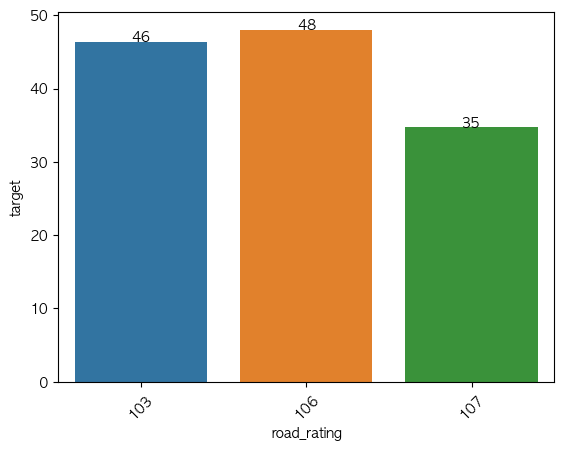

In [141]:
plt.xticks(rotation=45)


ax2=sns.barplot(x='road_rating',y='target',data=df_groupby_road)

for p in ax2.patches:
    ax2.text(p.get_x() + p.get_width() / 2,
            p.get_y() + p.get_height() ,
            f"{p.get_height():.0f}", 
            ha='center')
plt.show()


- 시도 군도일떄 속도가 느리다. 

## 요일(day_of_week)

In [113]:
df_train['day_of_week'].value_counts()

day_of_week
금    684024
수    675583
목    674070
일    673632
토    669767
화    662498
월    661643
Name: count, dtype: int64

In [114]:
df_day_target=groupby_target('day_of_week')
df_day_target=df_day_target.rename(index=df_day_target['day_of_week'])
df_day_target= df_day_target.reindex(index=['월','화','수','목','금','토','일'])
df_day_target

,day_of_week,target
월,월,42.761365
화,화,42.699198
수,수,42.770372
목,목,42.768345
금,금,42.450328
토,토,42.894117
일,일,43.179300


[Text(0.5, 1.0, '요일별 평균 속도')]

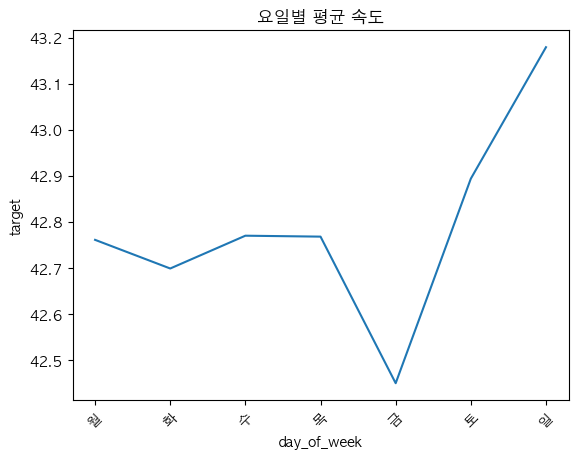

In [115]:
plt.xticks(rotation=45)
sns.lineplot(x='day_of_week',y='target',data=df_day_target).set(title='요일별 평균 속도')

- 원래 평일(월,화,수,목,금)과 공휴일(토,일,공휴일)로 컬럼을 나눌 계획이였으나 그래프를 보면 금요일에 유난히 평균속도가 느린것을  확인 할 수 있다.  따라서 금요일따로 분류하기로 결정 

## 달(month)

In [116]:
df_month_target=groupby_target('month')
df_month_target

,month,target
0,1,43.033130
1,2,43.256182
2,3,43.548673
3,5,42.639328
4,6,42.614157
5,7,36.282302
6,9,43.694340
7,10,43.495717
8,11,43.728215
9,12,43.030021


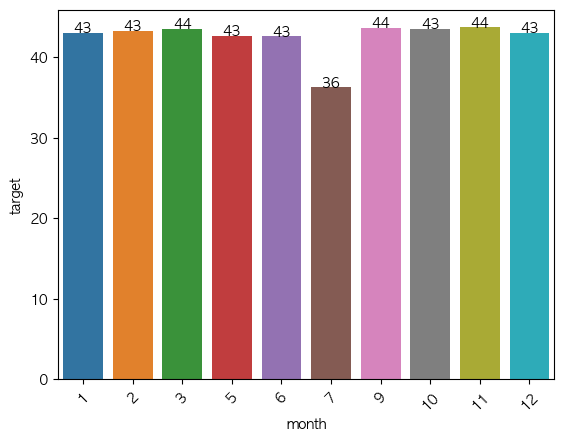

In [117]:
plt.xticks(rotation=45)
ax1=sns.barplot(x='month',y='target',data=df_month_target)

for p in ax1.patches:
    ax1.text(p.get_x() + p.get_width() / 2,
            p.get_y() + p.get_height() ,
            f"{p.get_height():.0f}", 
            ha='center')
plt.show()

- 각 달별 평균 속도를 통해 7월달에 유난히 속도가 느린것을 확인 할 수 있다. 7월은 휴가철이기때문에 차량이 증가하여 속도가 느려졌을것으로 판단. 
- 우리가 예측해야할 8월 또한 휴가철이므로 영향을 많이 받을 것으로 예상하여, 방학기간인 1,2,7,8 그외 학기 중으로 컬럼을 추가할 계획 

## 시각화

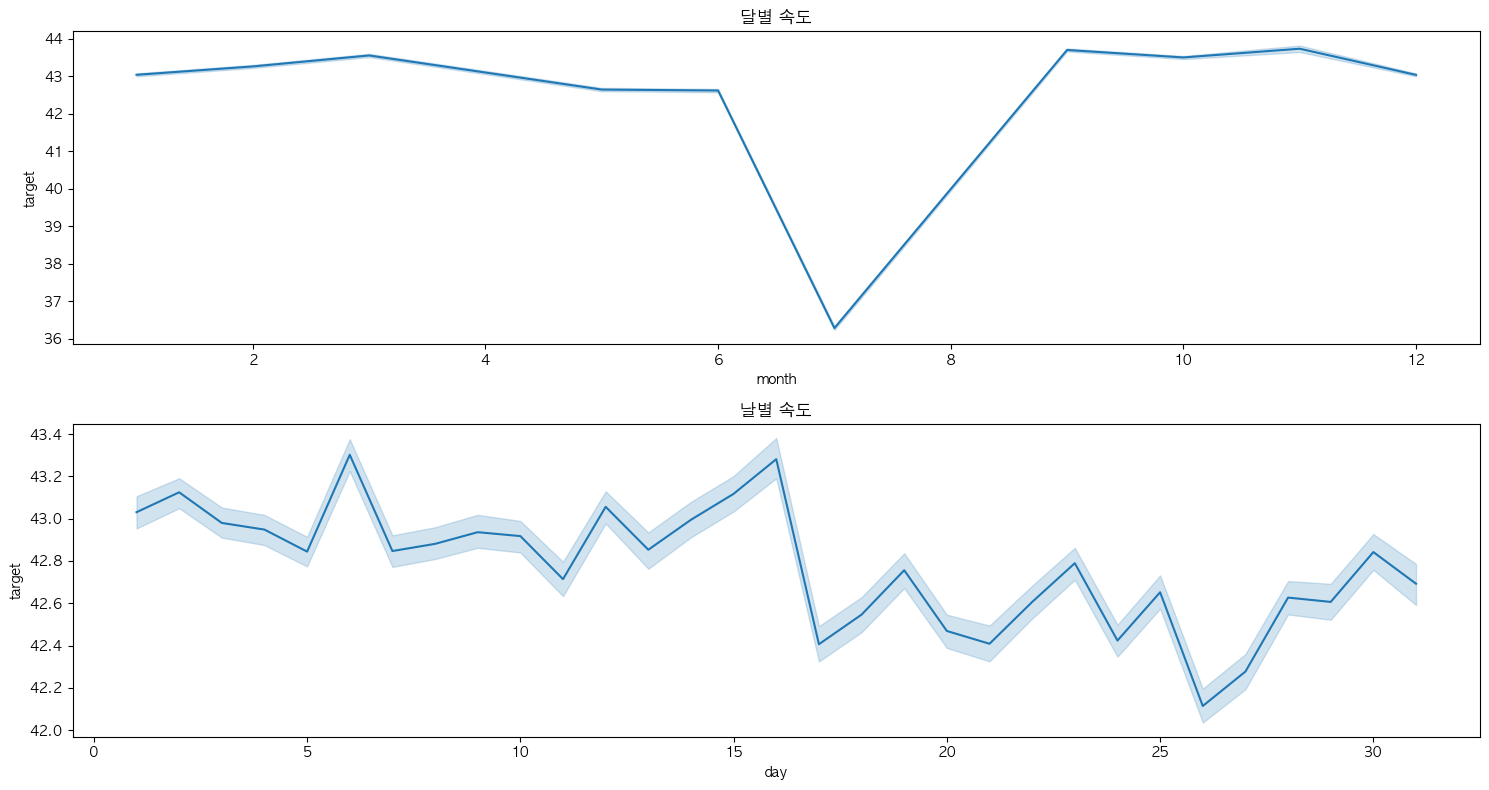

In [122]:
#달,
fig, axes = plt.subplots(2, figsize=(15,8))

sns.lineplot(x='month',y='target',data=df_train_day,ax=axes[0]).set(title='달별 속도')
sns.lineplot(x='day',y='target',data=df_train_day,ax=axes[1]).set(title='날별 속도')

plt.tight_layout()
plt.show()

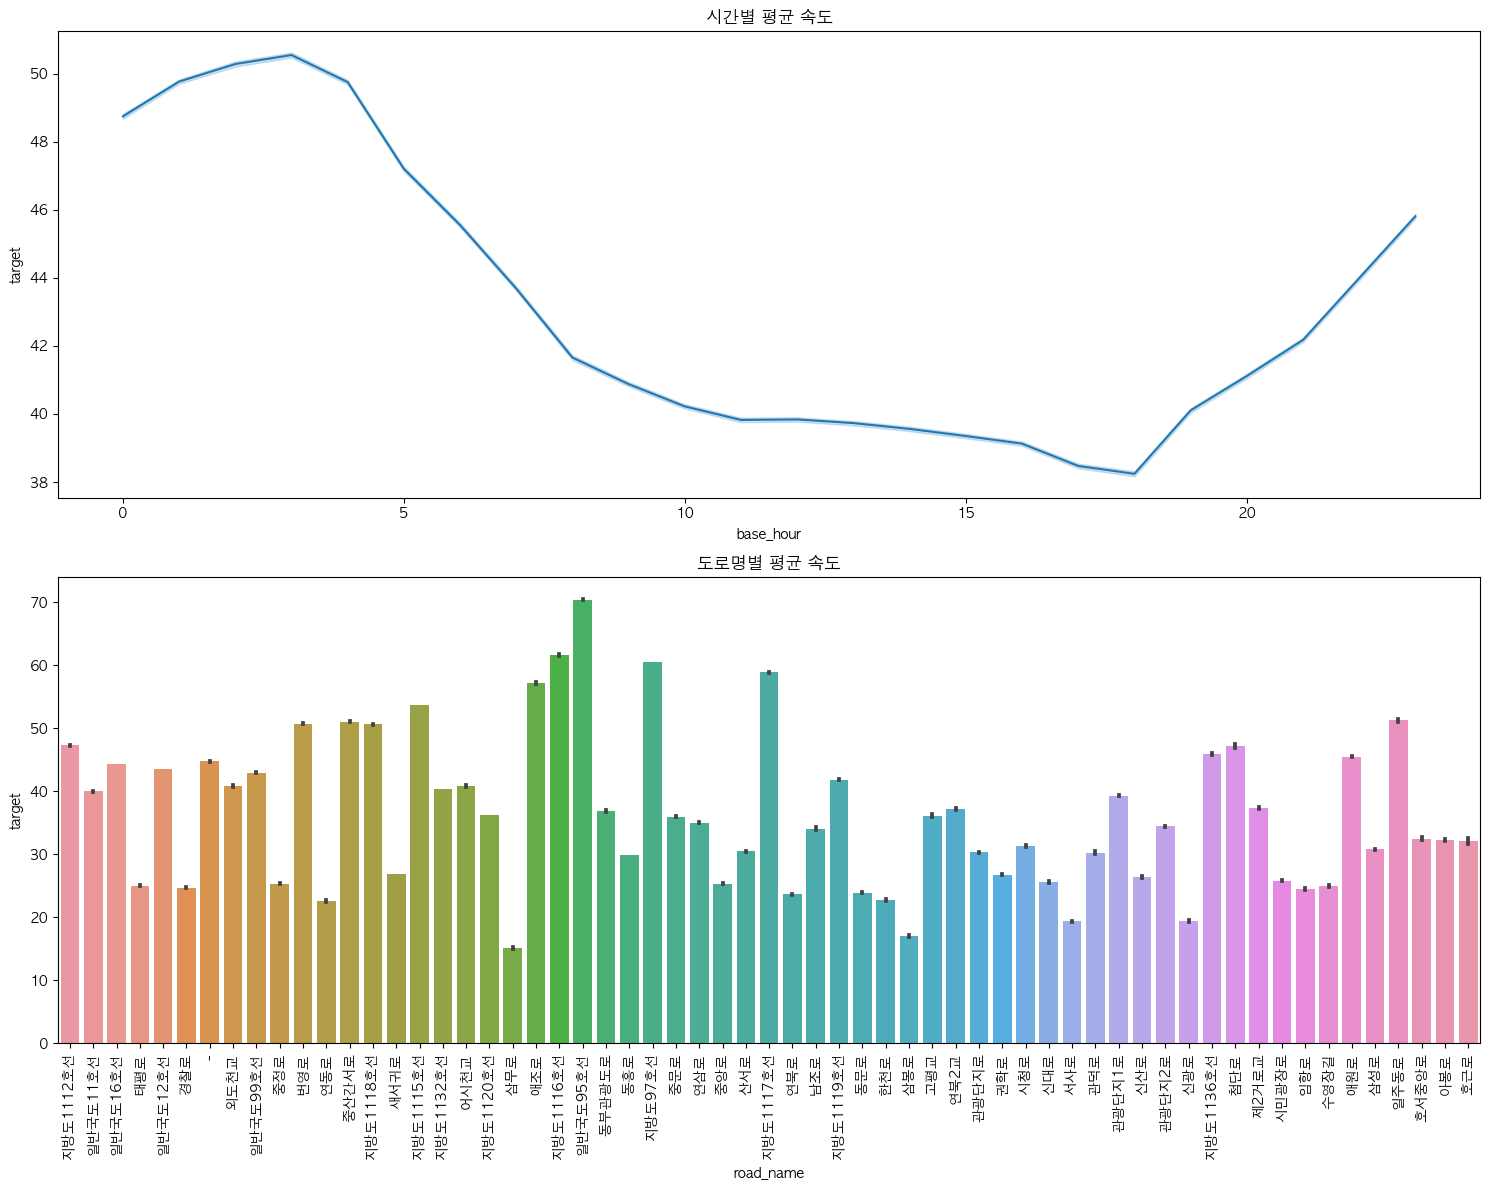

In [125]:
fig, axes = plt.subplots(2, figsize=(15,12))

sns.lineplot(x='base_hour',y='target',data=df_train_day,ax=axes[0]).set(title='시간별 평균 속도')
sns.barplot(x='road_name',y='target',data=df_train_day,ax=axes[1]).set(title='도로명별 평균 속도')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Feature Engineering

## 제주공항까지 거리 

- Haversine 공식으로 거리 계산.

In [126]:
def airport(row):
  
    lon1 = 126.4913534
    lat1 = 33.5104135
    lon2 = (row['start_longitude'] + row['end_longitude']) / 2
    lat2 = (row['start_latitude'] + row['end_latitude']) / 2

    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
   
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km


In [127]:
#train 데이터
df_train_air=df_train_day.copy()
df_train_air['airport_distance'] = df_train_air.apply(airport, axis=1)

#test 데이터
df_test_air=df_test_day.copy()
df_test_air['airport_distance'] = df_test_air.apply(airport, axis=1)

In [128]:
df_train_air.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,end_latitude,end_longitude,end_turn_restricted,target,rain_snow,week,year,month,day,airport_distance
0,TRAIN_0000000,2022-06-23,목,17,1,106,지방도1112호선,0,0,60.0,...,33.427749,126.662335,없음,52.0,눈비,0.0,2022,6,23,18.330548
1,TRAIN_0000001,2022-07-28,목,21,2,103,일반국도11호선,0,0,60.0,...,33.504811,126.526240,없음,30.0,눈비,0.0,2022,7,28,3.470872
2,TRAIN_0000002,2021-10-10,일,7,2,103,일반국도16호선,0,0,80.0,...,33.280072,126.362147,없음,61.0,눈비,2.0,2021,10,10,28.185912
3,TRAIN_0000003,2022-03-11,금,13,2,107,태평로,0,0,50.0,...,33.245565,126.566228,없음,20.0,없음,1.0,2022,3,11,30.222870
4,TRAIN_0000004,2021-10-05,화,8,2,103,일반국도12호선,0,0,80.0,...,33.462677,126.330152,없음,38.0,없음,0.0,2021,10,5,16.019878


## 거리 
- Haversine 공식으로 거리 계산
- 시작점과 도착지점 사이의 거리 

In [129]:
def distance(row):

    lon1 = row['start_longitude']
    lat1 = row['start_latitude']
    lon2 = row['end_longitude']
    lat2 = row['end_latitude']

    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km

In [130]:
#train 데이터
df_train_dis=df_train_air.copy()
df_train_dis['distance'] = df_train_dis.apply(distance, axis=1)

#test 데이터 
df_test_dis=df_test_air.copy()
df_test_dis['distance'] = df_test_dis.apply(distance, axis=1)

In [131]:
df_train_dis.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,end_longitude,end_turn_restricted,target,rain_snow,week,year,month,day,airport_distance,distance
0,TRAIN_0000000,2022-06-23,목,17,1,106,지방도1112호선,0,0,60.0,...,126.662335,없음,52.0,눈비,0.0,2022,6,23,18.330548,0.025694
1,TRAIN_0000001,2022-07-28,목,21,2,103,일반국도11호선,0,0,60.0,...,126.526240,없음,30.0,눈비,0.0,2022,7,28,3.470872,0.525560
2,TRAIN_0000002,2021-10-10,일,7,2,103,일반국도16호선,0,0,80.0,...,126.362147,없음,61.0,눈비,2.0,2021,10,10,28.185912,0.608016
3,TRAIN_0000003,2022-03-11,금,13,2,107,태평로,0,0,50.0,...,126.566228,없음,20.0,없음,1.0,2022,3,11,30.222870,0.107285
4,TRAIN_0000004,2021-10-05,화,8,2,103,일반국도12호선,0,0,80.0,...,126.330152,없음,38.0,없음,0.0,2021,10,5,16.019878,0.337736


## 방학과 학기 중으로 구간 나누기 
- 1,2,7,8 월 = `방학`
- 3,4,5,6,9,10,11,12 월 = `학기`

In [132]:
def vacation(df): 
    df['vacation'] = '-'
    df.loc[(df['month'] == 7) | (df['month'] == 8) | (df['month'] == 1) | (df['month'] == 2), 'vacation'] = '방학'
    df.loc[(df['month'] == 3) | (df['month'] == 4) | (df['month'] == 5) | (df['month'] == 6) | (df['month'] == 9) | (df['month'] == 10) | (df['month'] == 11) | (df['month'] == 12), 'vacation'] = '학기'
    df.loc[(df['vacation']=='-'), 'vacation'] = 'Na'
    return df

In [133]:
#train 데이터
df_train_vac = df_train_dis.copy()
df_train_vac = vacation(df_train_vac)

#test 데이터
df_test_vac = df_test_dis.copy()
df_test_vac = vacation(df_test_vac)


## 제주도 도심, 서귀포시 도심 출발 도착 표시

- 경도,위도를 통해 `제주 도심`(1), `서귀포 도심`(2) , 그 외 `외곽`(0)으로 분류
- 제주시 도심 : 126.4531517 ~ 126.5900257 , 33.4670429 ~
- 서귀포 도심 : 126.3972753 ~ 126.6076604 , ~ 33.2686052


In [134]:
train_center=df_train_vac.copy()
test_center=df_test_vac.copy()

# train 데이터 
train_jj_start = (train_center['start_longitude'] > 126.4531517) & (train_center['start_longitude']< 126.5900257) & (train_center['start_latitude'] > 33.4670429)
train_jj_end = (train_center['end_longitude'] > 126.4531517) & (train_center['end_longitude']< 126.5900257) & (train_center['end_latitude'] > 33.4670429)

train_sgp_start = (train_center['start_longitude'] > 126.3972753) & (train_center['start_longitude']< 126.6076604) & (train_center['start_latitude'] < 33.2686052)
train_sgp_end = (train_center['end_longitude'] > 126.3972753) & (train_center['end_longitude']< 126.6076604) & (train_center['end_latitude'] < 33.2686052)

# test 데이터 
test_jj_start = (test_center['start_longitude'] > 126.4531517) & (test_center['start_longitude']< 126.5900257) & (test_center['start_latitude'] > 33.4670429)
test_jj_end = (test_center['end_longitude'] > 126.4531517) & (test_center['end_longitude']< 126.5900257) & (test_center['end_latitude'] > 33.4670429)

test_sgp_start = (test_center['start_longitude'] > 126.3972753) & (test_center['start_longitude']< 126.6076604) & (test_center['start_latitude'] < 33.2686052)
test_sgp_end = (test_center['end_longitude'] > 126.3972753) & (test_center['end_longitude']< 126.6076604) & (test_center['end_latitude'] < 33.2686052)

In [135]:
# train 데이터 시작점
train_center['center_start'] = 0
train_center.loc[train_jj_start, 'center_start'] = 1
train_center.loc[train_sgp_start, 'center_start'] = 2

# train 데이터 도착점 
train_center['center_end'] = 0
train_center.loc[train_jj_end, 'center_end'] = 1
train_center.loc[train_sgp_end, 'center_end'] = 2

# test 데이터 시작점
test_center['center_start'] = 0
test_center.loc[test_jj_start, 'center_start'] = 1
test_center.loc[test_sgp_start, 'center_start'] = 2

# test 데이터 도착점
test_center['center_end'] = 0
test_center.loc[test_jj_end, 'center_end'] = 1
test_center.loc[test_sgp_end, 'center_end'] = 2


# Final train, test dataset to parquet

In [136]:
test_center.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,rain_snow,week,year,month,day,airport_distance,distance,vacation,center_start,center_end
0,TEST_000000,2022-08-25,목,17,3,107,연삼로,0,0,70.0,...,없음,0.0,2022,8,25,4.881938,0.278752,방학,1,1
1,TEST_000001,2022-08-09,화,12,2,103,일반국도12호선,0,0,70.0,...,눈비,0.0,2022,8,9,28.756351,1.038287,방학,2,2
2,TEST_000002,2022-08-05,금,2,1,103,일반국도16호선,0,0,60.0,...,눈비,1.0,2022,8,5,27.967410,0.171335,방학,2,2
3,TEST_000003,2022-08-18,목,23,3,103,일반국도11호선,0,0,70.0,...,없음,0.0,2022,8,18,6.572143,0.270917,방학,1,1
4,TEST_000004,2022-08-10,수,17,3,106,번영로,0,0,70.0,...,눈비,0.0,2022,8,10,7.871524,1.225101,방학,1,1


In [137]:
train_center.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,rain_snow,week,year,month,day,airport_distance,distance,vacation,center_start,center_end
0,TRAIN_0000000,2022-06-23,목,17,1,106,지방도1112호선,0,0,60.0,...,눈비,0.0,2022,6,23,18.330548,0.025694,학기,0,0
1,TRAIN_0000001,2022-07-28,목,21,2,103,일반국도11호선,0,0,60.0,...,눈비,0.0,2022,7,28,3.470872,0.525560,방학,1,1
2,TRAIN_0000002,2021-10-10,일,7,2,103,일반국도16호선,0,0,80.0,...,눈비,2.0,2021,10,10,28.185912,0.608016,학기,0,0
3,TRAIN_0000003,2022-03-11,금,13,2,107,태평로,0,0,50.0,...,없음,1.0,2022,3,11,30.222870,0.107285,학기,2,2
4,TRAIN_0000004,2021-10-05,화,8,2,103,일반국도12호선,0,0,80.0,...,없음,0.0,2021,10,5,16.019878,0.337736,학기,0,0


In [ ]:
train_center.to_parquet('data/final_train.parquet')
test_center.to_parquet('data/final_test.parquet')